## Support Vector Machines 

My summary of SVMs based on my notes from the Applied Machine Learning course from University of Michagan 
* SVMs has a similar form of linear regression, but the outpout of the linear function is transformed (e.g. Sin function) to produce binary outpout with 2 possible values  
* This means converting the description of the line (that seperates the classes) into a form that be used as a decision rule for a classifier
* Classifier Margin: Maximum width the decision boundary can be extended before hitting a data point
* One way to define a good classifier is to reward for the amount of seperation between classes 
* Maximum margin classifier: the linear classifier with maximum margin = Linear SVM 

## Kernalized Support Vector Machines 

* When classes in a dataset are not linearly seperable, it is sometimes impossible to classify them with a linear classifier, such as a Linear SVM
* A powerful extension of LSVMs is KSVMs which provides more complex models beyond linearity. 
* KSVM take the original input data space and transform it into a higher-dimesnional feature-space where it becomes easier to classify the data using a linear classifer (e.g. mapping each 1-D point to a 2-D pair)
* With this transformation, we can find a hyper-plane (say z=0.9) that easily seperates the classes 
* different kernels corrspond to different transformations to that higher dimensional feature-space
* Kernels: RBF (Radial Basis Function), (Polynomial), ...

* The Kernel trick & Vapnik 

### Important parameters 
* __C__: Regularization

    * Increasing C reduces regularization and results in more model complexity. This will cause the model to fit the training data with as few errors as possible even if it means a smaller classifier margin 
    * Reducing C increases regularization, simpler models, encourages classifier to find larger classifier margin even if that decision boundary leads to more points being misclassified


* __Kernel specific:RBF - Gamma__: Radius of similarity
    * Increasing gamma = sharpening the kernel = the kernel values decay more rapidly. Which means points have to be very close to be considered similar
    * Decreasing gamma = Large similarity radius, so points further apart from each other are considered similar = more points grouped together = smoother decision boundaries


In [1]:
%matplotlib inline
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn import metrics, preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from IPython.display import Image, display


In [2]:
# loading the data, pre-paring features and labels 
data = pd.read_csv('data.csv', index_col=False)
data.drop('id',axis=1, inplace=True)
data = data.values
X = data[:,1:31] # features
y = data[:,0]

# Converting categorical labels to numerical 0,1
le = LabelEncoder()
y = le.fit_transform(y)

# Feature - Normalization 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


C:\Users\AdamO\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\AdamO\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


##  Single Split

In [3]:
# single split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3
                                                    , random_state=0, stratify=y)
clf = SVC(probability=True).fit(X_train, y_train)

print("Training set accuracy: {}".format(clf.score(X_train, y_train)))
print("Test set accuracy: {}".format(clf.score(X_test, y_test)))
      
      

Training set accuracy: 0.9899497487437185
Test set accuracy: 0.9532163742690059


## Cross Validation
* Cross Validation goes beyond using a single train-test to evaluate performance by using multiple train-test splits (Number of folds)
* K-fold cross validation: Training the model using all folds except for one (for evaluation)
* Leave-one-out cross validation is an example of an extreme case, where each sample is a single fold


In [4]:
# 3-Fold Cross Validation 
cv_error = cross_val_score(clf, X_scaled, y, cv=3)
print('Accuracy scores: {}'.format(cv_error))
print('Average accuracy score: {}'.format(np.average(cv_error)))

Accuracy scores: [0.96315789 0.98421053 0.97354497]
Average accuracy score: 0.9736377981992016


### Example of feature selection with Cross Validation


* f_regression https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html
* Excellent discussion regarding this technique: https://stats.stackexchange.com/questions/204141/difference-between-selecting-features-based-on-f-regression-and-based-on-r2

In [5]:
from sklearn.feature_selection import SelectKBest, f_regression
# Best K features using 
clf2 = make_pipeline(SelectKBest(f_regression,k=3), SVC(probability=True))
scores = cross_val_score(clf2, X_scaled, y, cv=3)
print(scores)
print('Average accuracy score: {}'.format(np.average(scores)))

[0.93157895 0.95263158 0.94179894]
Average accuracy score: 0.9420031560382438


### By examining the above results:
* we can see that a subset of the features in this dataset can produce performance that is considerably similar to the performace of all features combined 
* Reducing the dataset to using only that subset saves computation time and costs


## Evaluation Metrics 
* Confusion matrix is helpful in the sense that it breaks down the classifier performace by the type of the error (Type II and Type I)
* The evaluation metric used should be alighned with the goal of the classification task
* Many useful evaluation metrics can be derived from the confusion matrix

In [6]:
# Confusion matrix 
y_pred = clf.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[103   4]
 [  4  60]]


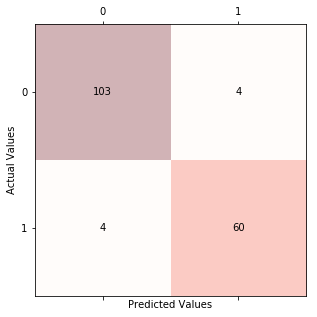

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Reds, alpha=0.3)

for i in range(cm.shape[0]):
     for j in range(cm.shape[1]):
         ax.text(x=j, y=i,
                s=cm[i, j], 
                va='center', ha='center')
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values')
plt.show()


In [8]:
print(classification_report(y_test, y_pred ))

             precision    recall  f1-score   support

          0       0.96      0.96      0.96       107
          1       0.94      0.94      0.94        64

avg / total       0.95      0.95      0.95       171



### By examining the above results  
* From the confusion matrix, we can see that out of 171 predictions, 163 were correct 
* (True negative 103 + false negative 4) = 107 samples are as negative (healthy tissue)
* (60+4) = 64 samples are positive (cancerous tissue)
* FP = Type I error 
* FN = Type II error

#### Metric calcuation summary: 

* __Accuracy__: (TP+TN)/total = (60+103)/171 = 0.95

* __ Classification Error__ : (FP+FN)/total = (4+4)/171 = 0.05


* __Recall / True Positive Rate (TPR )/Sensitivity __ = : TP/TP+FN  = 60/64 = 0.94
TPR is the fraction of all positive instances that were correctly predicted as positive

* __ Precision__ : TP/TP+FP = 60/ 60 + 4 = 0.94


* __ False Positive Rate  __ = FP/FP + TN = 4/4+103 = 0.04
FPR is the fraction of all negative instances that were incorrectly predicted as positive

* __ True Negative Rate__ =  TN / (FP + TN) = 103 / 107 = 0.96  



* Combining percision and recall = 2. (Percision * Recall)/(Percision + Recall)
    * Based on the harmonic mean of percision and recall
    * its a special case of the more general evaluation metric = F Score
    * Introudces parameter Beta: controles the emphasis on percision / recall
    * B=1 >> F1 Score, B>
    * since we want to reduce FN as much as possible for this task, 
        we set B = 0.5 ((FP hurt performace more than FNs ))
    * When B = 2 > Recall oriented situations 
      
####  For this Medical Application we want to reduce type II (False negative) error as much as possible (increasing recall), because the consequences of this error in this case is very serious. It is preferred that the classifier "errors" as a safty measure, instead of predicting a sample that is cancerious as healthy. 
* percision deals with type type I error 

C:\Users\AdamO\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


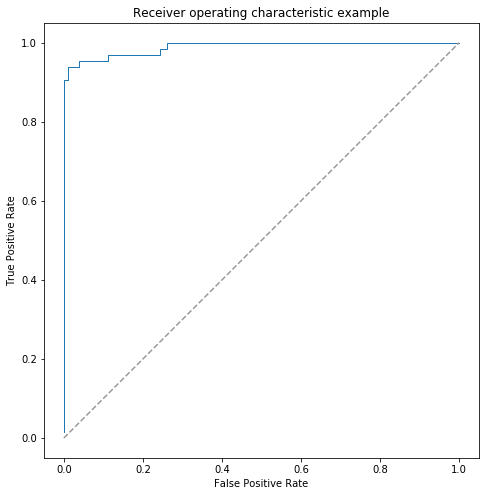

In [9]:
# Plot the receiver operating characteristic curve (ROC).
plt.figure(figsize=(10,8))

probas_ = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC fold (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')


plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.axes().set_aspect(1)

## Interpretation

* The diagonal line in the middle represents random guessing, no better than a dummy classifier
* The more we shift towards the top left corner, the better the performace
* The more we shift towards top left,  the more True Positive Rate > Flase Positive Rate
